In [12]:
from __future__ import division, print_function
from keras import backend as K
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline

In [13]:
# In [2]:
DATA_DIR = ""
IMAGE_DIR = os.path.join(DATA_DIR, "images")

BATCH_SIZE = 32
NUM_EPOCHS = 1000

In [14]:
image_groups = {}
for image_name in os.listdir(IMAGE_DIR):
    base_name = image_name[0:-4]
    group_name = base_name[0:4]
    if group_name in image_groups:
        image_groups[group_name].append(image_name)
    else:
        image_groups[group_name] = [image_name]
num_sims = 0
image_triples = []
group_list = sorted(list(image_groups.keys()))
for i, g in enumerate(group_list):
    if num_sims % 100 == 0:
        print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                .format(num_sims, num_sims, 2*num_sims))
    images_in_group = image_groups[g]
    sim_pairs_it = itertools.combinations(images_in_group, 2)
    # for each similar pair, generate a corresponding different pair
    for ref_image, sim_image in sim_pairs_it:
        image_triples.append((ref_image, sim_image, 1))
        num_sims += 1
        while True:
            j = np.random.randint(low=0, high=len(group_list), size=1)[0]
            if j != i:
                break
        dif_image_candidates = image_groups[group_list[j]]
        k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
        dif_image = dif_image_candidates[k]
        image_triples.append((ref_image, dif_image, 0))
print("Generated {:d} pos + {:d} neg = {:d} total image triples"
        .format(num_sims, num_sims, 2*num_sims))

Generated 0 pos + 0 neg = 0 total image triples
Generated 900 pos + 900 neg = 1800 total image triples
Generated 1656 pos + 1656 neg = 3312 total image triples


In [4]:
image_triples

[('010006.jpg', '010003.jpg', 1),
 ('010006.jpg', '400009.jpg', 0),
 ('010006.jpg', '010004.jpg', 1),
 ('010006.jpg', '390001.jpg', 0),
 ('010006.jpg', '010007.jpg', 1),
 ('010006.jpg', '150007.jpg', 0),
 ('010006.jpg', '010001.jpg', 1),
 ('010006.jpg', '120003.jpg', 0),
 ('010006.jpg', '010005.jpg', 1),
 ('010006.jpg', '170001.jpg', 0),
 ('010006.jpg', '010008.jpg', 1),
 ('010006.jpg', '200008.jpg', 0),
 ('010006.jpg', '010009.jpg', 1),
 ('010006.jpg', '430009.jpg', 0),
 ('010006.jpg', '010002.jpg', 1),
 ('010006.jpg', '390007.jpg', 0),
 ('010003.jpg', '010004.jpg', 1),
 ('010003.jpg', '220009.jpg', 0),
 ('010003.jpg', '010007.jpg', 1),
 ('010003.jpg', '130008.jpg', 0),
 ('010003.jpg', '010001.jpg', 1),
 ('010003.jpg', '050004.jpg', 0),
 ('010003.jpg', '010005.jpg', 1),
 ('010003.jpg', '320005.jpg', 0),
 ('010003.jpg', '010008.jpg', 1),
 ('010003.jpg', '160001.jpg', 0),
 ('010003.jpg', '010009.jpg', 1),
 ('010003.jpg', '370005.jpg', 0),
 ('010003.jpg', '010002.jpg', 1),
 ('010003.jpg'

In [15]:
# In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if group_name in image_groups:
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples   

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "r")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def train_test_split(triples, splits):
    assert sum(splits) == 1.0
    split_pts = np.cumsum(np.array([0.] + splits))
    indices = np.random.permutation(np.arange(len(triples)))
    shuffled_triples = [triples[i] for i in indices]
    data_splits = []
    for sid in range(len(splits)):
        start = int(split_pts[sid] * len(triples))
        end = int(split_pts[sid + 1] * len(triples))
        data_splits.append(shuffled_triples[start:end])
    return data_splits

def batch_to_vectors(batch, vec_size, vec_dict):
    X1 = np.zeros((len(batch), vec_size))
    X2 = np.zeros((len(batch), vec_size))
    Y = np.zeros((len(batch), 2))
    for tid in range(len(batch)):
        X1[tid] = vec_dict[batch[tid][0]]
        X2[tid] = vec_dict[batch[tid][1]]
        Y[tid] = [1, 0] if batch[tid][2] == 0 else [0, 1]
    return ([X1, X2], Y)
    
def data_generator(triples, vec_size, vec_dict, batch_size=32):
    while True:
        # shuffle once per batch
        indices = np.random.permutation(np.arange(len(triples)))
        num_batches = len(triples) // batch_size
        for bid in range(num_batches):
            batch_indices = indices[bid * batch_size : (bid + 1) * batch_size]
            batch = [triples[i] for i in batch_indices]
            yield batch_to_vectors(batch, vec_size, vec_dict)

def evaluate_model(model_file, test_gen):
    model_name = os.path.basename(model_file)
    model = load_model(model_file)
    print("=== Evaluating model: {:s} ===".format(model_name))
    ytrue, ypred = [], []
    num_test_steps = len(test_triples) // BATCH_SIZE
    for i in range(num_test_steps):
        (X1, X2), Y = test_gen.__next__()
        Y_ = model.predict([X1, X2])
        ytrue.extend(np.argmax(Y, axis=1).tolist())
        ypred.extend(np.argmax(Y_, axis=1).tolist())
    accuracy = accuracy_score(ytrue, ypred)
    print("\nAccuracy: {:.3f}".format(accuracy))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytrue, ypred))
    print("\nClassification Report")
    print(classification_report(ytrue, ypred))
    return accuracy

def get_model_file(data_dir, vector_name, merge_mode, borf):
    return os.path.join(data_dir, "models", "A_A_{:s}-{:s}-{:s}_1000_Nadam.h5"
                        .format(vector_name, merge_mode, borf))

In [16]:
# Declare and Extract Common Data
# In [4]:
VECTORIZERS = ["InceptionV3", "ResNet"]
# VECTORIZERS = ["VGG16", "VGG19", "InceptionV3", "ResNet"]
MERGE_MODES = ["Concat", "Dot", "AbsDiff", "Euclidean"]
scores = np.zeros((len(VECTORIZERS), len(MERGE_MODES)))
# In [5]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 900 pos + 900 neg = 1800 total image triples
Generated 1656 pos + 1656 neg = 3312 total image triples


In [17]:
# In [6]:
train_triples, val_triples, test_triples = train_test_split(image_triples, 
                                                            splits=[0.7, 0.1, 0.2])
print(len(train_triples), len(val_triples), len(test_triples))

# InceptionV3 Vectors
# In [7]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-inception-vectors.tsv")
# In [8]:
vec_dict = load_vectors(VECTOR_FILE)

2318 331 663


Epoch 1/1000
72/72 [==============================] - 2s 22ms/step - loss: 1.5952 - acc: 0.4891 - val_loss: 0.6883 - val_acc: 0.5531
Epoch 2/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.6980 - acc: 0.5317 - val_loss: 0.6913 - val_acc: 0.5531
Epoch 3/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.6832 - acc: 0.5586 - val_loss: 0.6557 - val_acc: 0.6500
Epoch 4/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.6627 - acc: 0.5964 - val_loss: 0.6976 - val_acc: 0.5000
Epoch 5/1000
72/72 [==============================] - 1s 20ms/step - loss: 0.6083 - acc: 0.6662 - val_loss: 0.5245 - val_acc: 0.7750
Epoch 6/1000
72/72 [==============================] - 3s 42ms/step - loss: 0.5144 - acc: 0.7461 - val_loss: 0.3478 - val_acc: 0.8438
Epoch 7/1000
72/72 [==============================] - 2s 22ms/step - loss: 0.3907 - acc: 0.8199 - val_loss: 0.2961 - val_acc: 0.9125
Epoch 8/1000
72/72 [==============================] - 2s 28ms/step - 

72/72 [==============================] - 1s 16ms/step - loss: 0.0329 - acc: 0.9883 - val_loss: 0.0265 - val_acc: 0.9969
Epoch 63/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0335 - acc: 0.9896 - val_loss: 0.0127 - val_acc: 0.9938
Epoch 64/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0341 - acc: 0.9883 - val_loss: 0.0122 - val_acc: 0.9938
Epoch 65/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0764 - acc: 0.9740 - val_loss: 0.0557 - val_acc: 0.9812
Epoch 66/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0853 - acc: 0.9731 - val_loss: 0.0423 - val_acc: 0.9844
Epoch 67/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0382 - acc: 0.9883 - val_loss: 0.0729 - val_acc: 0.9750
Epoch 68/1000
72/72 [==============================] - 1s 20ms/step - loss: 0.1037 - acc: 0.9696 - val_loss: 0.0138 - val_acc: 1.0000
Epoch 69/1000
72/72 [==============================] - 1s 17ms/step - loss: 

72/72 [==============================] - 1s 12ms/step - loss: 0.0383 - acc: 0.9887 - val_loss: 0.0083 - val_acc: 0.9969
Epoch 124/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0278 - acc: 0.9926 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 125/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0166 - acc: 0.9948 - val_loss: 0.0097 - val_acc: 0.9969
Epoch 126/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0314 - acc: 0.9922 - val_loss: 0.0056 - val_acc: 1.0000
Epoch 127/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0277 - acc: 0.9931 - val_loss: 0.0163 - val_acc: 0.9906
Epoch 128/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0224 - acc: 0.9935 - val_loss: 0.0257 - val_acc: 0.9969
Epoch 129/1000
72/72 [==============================] - 2s 31ms/step - loss: 0.0279 - acc: 0.9922 - val_loss: 0.1038 - val_acc: 0.9812
Epoch 130/1000
72/72 [==============================] - 1s 12ms/step -

Epoch 184/1000
72/72 [==============================] - 2s 23ms/step - loss: 0.0288 - acc: 0.9918 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 185/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0106 - acc: 0.9961 - val_loss: 0.0381 - val_acc: 0.9812
Epoch 186/1000
72/72 [==============================] - 2s 27ms/step - loss: 0.0183 - acc: 0.9970 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 187/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0197 - acc: 0.9926 - val_loss: 0.0129 - val_acc: 0.9906
Epoch 188/1000
72/72 [==============================] - 2s 26ms/step - loss: 0.0469 - acc: 0.9844 - val_loss: 0.0083 - val_acc: 0.9969
Epoch 189/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0099 - acc: 0.9974 - val_loss: 0.0188 - val_acc: 0.9938
Epoch 190/1000
72/72 [==============================] - 2s 27ms/step - loss: 0.0196 - acc: 0.9939 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 191/1000
72/72 [==============================] -

Epoch 245/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0131 - acc: 0.9961 - val_loss: 0.0122 - val_acc: 0.9938
Epoch 246/1000
72/72 [==============================] - 2s 22ms/step - loss: 0.0191 - acc: 0.9944 - val_loss: 0.0085 - val_acc: 1.0000
Epoch 247/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 0.0090 - val_acc: 0.9969
Epoch 248/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0201 - acc: 0.9961 - val_loss: 0.0598 - val_acc: 0.9875
Epoch 249/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0289 - acc: 0.9918 - val_loss: 0.0164 - val_acc: 0.9969
Epoch 250/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0298 - acc: 0.9926 - val_loss: 0.0224 - val_acc: 0.9938
Epoch 251/1000
72/72 [==============================] - 2s 22ms/step - loss: 0.0143 - acc: 0.9952 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 252/1000
72/72 [==============================] -

Epoch 306/1000
72/72 [==============================] - 2s 28ms/step - loss: 0.0065 - acc: 0.9987 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 307/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0059 - acc: 0.9978 - val_loss: 0.0270 - val_acc: 0.9938
Epoch 308/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0105 - val_acc: 0.9938
Epoch 309/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0267 - acc: 0.9952 - val_loss: 0.0322 - val_acc: 0.9906
Epoch 310/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0197 - acc: 0.9965 - val_loss: 0.0109 - val_acc: 0.9938
Epoch 311/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0221 - acc: 0.9944 - val_loss: 0.0241 - val_acc: 0.9938
Epoch 312/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0328 - acc: 0.9913 - val_loss: 0.0326 - val_acc: 0.9812
Epoch 313/1000
72/72 [==============================] -

72/72 [==============================] - 2s 23ms/step - loss: 0.0180 - acc: 0.9952 - val_loss: 0.0084 - val_acc: 0.9938
Epoch 367/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0066 - acc: 0.9987 - val_loss: 0.0077 - val_acc: 0.9969
Epoch 368/1000
72/72 [==============================] - 2s 28ms/step - loss: 0.0024 - acc: 0.9996 - val_loss: 0.0056 - val_acc: 0.9969
Epoch 369/1000
72/72 [==============================] - 1s 20ms/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0117 - val_acc: 0.9938
Epoch 370/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0049 - acc: 0.9987 - val_loss: 0.0073 - val_acc: 0.9969
Epoch 371/1000
72/72 [==============================] - 2s 21ms/step - loss: 0.0074 - acc: 0.9991 - val_loss: 0.0070 - val_acc: 0.9969
Epoch 372/1000
72/72 [==============================] - 2s 22ms/step - loss: 0.0025 - acc: 0.9991 - val_loss: 0.0128 - val_acc: 0.9938
Epoch 373/1000
72/72 [==============================] - 1s 17ms/step -

Epoch 427/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0052 - acc: 0.9987 - val_loss: 0.0167 - val_acc: 0.9938
Epoch 428/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0049 - acc: 0.9983 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 429/1000
72/72 [==============================] - 2s 24ms/step - loss: 0.0184 - acc: 0.9957 - val_loss: 0.0468 - val_acc: 0.9812
Epoch 430/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.0129 - val_acc: 0.9969
Epoch 431/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0200 - acc: 0.9965 - val_loss: 0.0113 - val_acc: 0.9938
Epoch 432/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0070 - acc: 0.9978 - val_loss: 0.0101 - val_acc: 0.9969
Epoch 433/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0090 - acc: 0.9987 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 434/1000
72/72 [==============================] -

72/72 [==============================] - 1s 12ms/step - loss: 0.0137 - acc: 0.9961 - val_loss: 0.0085 - val_acc: 0.9969
Epoch 488/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0061 - acc: 0.9983 - val_loss: 0.0390 - val_acc: 0.9875
Epoch 489/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0218 - val_acc: 0.9906
Epoch 490/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0077 - acc: 0.9978 - val_loss: 0.1162 - val_acc: 0.9719
Epoch 491/1000
72/72 [==============================] - 2s 34ms/step - loss: 0.0236 - acc: 0.9944 - val_loss: 0.0052 - val_acc: 1.0000
Epoch 492/1000
72/72 [==============================] - 2s 34ms/step - loss: 0.0104 - acc: 0.9957 - val_loss: 0.0458 - val_acc: 0.9938
Epoch 493/1000
72/72 [==============================] - 1s 21ms/step - loss: 0.0281 - acc: 0.9926 - val_loss: 0.0071 - val_acc: 0.9969
Epoch 494/1000
72/72 [==============================] - 2s 28ms/step -

Epoch 548/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0130 - acc: 0.9978 - val_loss: 0.0696 - val_acc: 0.9750
Epoch 549/1000
72/72 [==============================] - 1s 19ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0038 - val_acc: 0.9969
Epoch 550/1000
72/72 [==============================] - 1s 21ms/step - loss: 0.0023 - acc: 0.9996 - val_loss: 9.7549e-04 - val_acc: 1.0000
Epoch 551/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0094 - acc: 0.9970 - val_loss: 0.0086 - val_acc: 0.9969
Epoch 552/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0135 - acc: 0.9970 - val_loss: 0.0346 - val_acc: 0.9906
Epoch 553/1000
72/72 [==============================] - 2s 22ms/step - loss: 0.0047 - acc: 0.9983 - val_loss: 9.2307e-04 - val_acc: 1.0000
Epoch 554/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0040 - acc: 0.9996 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 555/1000
72/72 [=========================

72/72 [==============================] - 1s 12ms/step - loss: 0.0115 - acc: 0.9961 - val_loss: 0.0066 - val_acc: 0.9969
Epoch 609/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.0144 - val_acc: 0.9938
Epoch 610/1000
72/72 [==============================] - 1s 20ms/step - loss: 0.0219 - acc: 0.9965 - val_loss: 0.0125 - val_acc: 0.9969
Epoch 611/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0162 - acc: 0.9965 - val_loss: 0.0141 - val_acc: 0.9938
Epoch 612/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0269 - acc: 0.9944 - val_loss: 0.0362 - val_acc: 0.9906
Epoch 613/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0164 - acc: 0.9970 - val_loss: 0.0865 - val_acc: 0.9812
Epoch 614/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0143 - acc: 0.9961 - val_loss: 0.0149 - val_acc: 0.9938
Epoch 615/1000
72/72 [==============================] - 1s 13ms/step -

Epoch 669/1000
72/72 [==============================] - 3s 40ms/step - loss: 0.0133 - acc: 0.9970 - val_loss: 0.0194 - val_acc: 0.9938
Epoch 670/1000
72/72 [==============================] - 2s 26ms/step - loss: 0.0174 - acc: 0.9957 - val_loss: 0.0219 - val_acc: 0.9938
Epoch 671/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0201 - acc: 0.9970 - val_loss: 0.0195 - val_acc: 0.9938
Epoch 672/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0120 - acc: 0.9974 - val_loss: 0.0100 - val_acc: 0.9969
Epoch 673/1000
72/72 [==============================] - 2s 27ms/step - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 674/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 675/1000
72/72 [==============================] - 2s 23ms/step - loss: 0.0122 - acc: 0.9978 - val_loss: 0.0571 - val_acc: 0.9844
Epoch 676/1000
72/72 [==============================] -

72/72 [==============================] - 1s 15ms/step - loss: 0.0102 - acc: 0.9974 - val_loss: 0.0135 - val_acc: 0.9969
Epoch 730/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0086 - acc: 0.9970 - val_loss: 0.0132 - val_acc: 0.9938
Epoch 731/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0129 - acc: 0.9978 - val_loss: 0.0251 - val_acc: 0.9969
Epoch 732/1000
72/72 [==============================] - 1s 19ms/step - loss: 0.0069 - acc: 0.9974 - val_loss: 0.0083 - val_acc: 0.9969
Epoch 733/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 6.3823e-04 - val_acc: 1.0000
Epoch 734/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0042 - acc: 0.9996 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 735/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0441 - val_acc: 0.9781
Epoch 736/1000
72/72 [==============================] - 1s 18ms/st

Epoch 790/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0088 - acc: 0.9991 - val_loss: 0.0274 - val_acc: 0.9969
Epoch 791/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0203 - acc: 0.9965 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 792/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0116 - acc: 0.9974 - val_loss: 0.0119 - val_acc: 0.9969
Epoch 793/1000
72/72 [==============================] - 2s 31ms/step - loss: 0.0101 - acc: 0.9974 - val_loss: 0.0056 - val_acc: 0.9969
Epoch 794/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0149 - acc: 0.9961 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 795/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0104 - acc: 0.9978 - val_loss: 0.0543 - val_acc: 0.9906
Epoch 796/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0105 - acc: 0.9978 - val_loss: 0.1367 - val_acc: 0.9844
Epoch 797/1000
72/72 [==============================] -

72/72 [==============================] - 2s 28ms/step - loss: 0.0326 - acc: 0.9952 - val_loss: 0.0120 - val_acc: 0.9969
Epoch 851/1000
72/72 [==============================] - 2s 24ms/step - loss: 0.0104 - acc: 0.9965 - val_loss: 0.0106 - val_acc: 0.9969
Epoch 852/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0080 - acc: 0.9983 - val_loss: 0.0058 - val_acc: 0.9969
Epoch 853/1000
72/72 [==============================] - 2s 26ms/step - loss: 0.0174 - acc: 0.9965 - val_loss: 0.0089 - val_acc: 0.9969
Epoch 854/1000
72/72 [==============================] - 2s 29ms/step - loss: 0.0210 - acc: 0.9952 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 855/1000
72/72 [==============================] - 2s 25ms/step - loss: 0.0096 - acc: 0.9978 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 856/1000
72/72 [==============================] - 1s 19ms/step - loss: 0.0123 - acc: 0.9970 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 857/1000
72/72 [==============================] - 1s 17ms/step -

72/72 [==============================] - 1s 18ms/step - loss: 0.0086 - acc: 0.9974 - val_loss: 0.0350 - val_acc: 0.9969
Epoch 911/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0155 - acc: 0.9965 - val_loss: 0.0559 - val_acc: 0.9906
Epoch 912/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0226 - acc: 0.9961 - val_loss: 0.0115 - val_acc: 1.0000
Epoch 913/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0094 - acc: 0.9983 - val_loss: 0.0496 - val_acc: 0.9906
Epoch 914/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0073 - acc: 0.9970 - val_loss: 0.0209 - val_acc: 0.9969
Epoch 915/1000
72/72 [==============================] - 2s 24ms/step - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0495 - val_acc: 0.9938
Epoch 916/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0076 - val_acc: 1.0000
Epoch 917/1000
72/72 [==============================] - 1s 12ms/step -

Epoch 971/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0297 - val_acc: 0.9969
Epoch 972/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0055 - acc: 0.9996 - val_loss: 0.0661 - val_acc: 0.9938
Epoch 973/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0141 - val_acc: 0.9906
Epoch 974/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0290 - acc: 0.9952 - val_loss: 0.0954 - val_acc: 0.9688
Epoch 975/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0419 - acc: 0.9935 - val_loss: 0.1506 - val_acc: 0.9281
Epoch 976/1000
72/72 [==============================] - 3s 37ms/step - loss: 0.0139 - acc: 0.9965 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 977/1000
72/72 [==============================] - 2s 31ms/step - loss: 0.0190 - acc: 0.9961 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 978/1000
72/72 [==============================] -

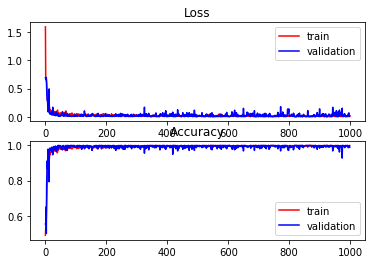

=== Evaluating model: A_A_inceptionv3-cat-final_1000_Nadam.h5 ===

Accuracy: 0.988

Confusion Matrix
[[309   1]
 [  7 323]]

Classification Report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       310
          1       1.00      0.98      0.99       330

avg / total       0.99      0.99      0.99       640

=== Evaluating model: A_A_inceptionv3-cat-best_1000_Nadam.h5 ===

Accuracy: 0.989

Confusion Matrix
[[306   5]
 [  2 327]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.98      0.99       311
          1       0.98      0.99      0.99       329

avg / total       0.99      0.99      0.99       640



In [18]:
# Input: Concatenate Vectors
# In [9]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [10]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Concatenate(axis=-1)([input_1, input_2]) ###

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

# In [11]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [12]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [13]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "cat", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [14]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [15]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "cat", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 0] = best_accuracy if best_accuracy > final_accuracy else final_accuracy

# Input: Elementwise Cosine Distance
# In [16]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

(10,) (10,)
(10,)
Epoch 1/1000
72/72 [==============================] - 1s 19ms/step - loss: 0.6050 - acc: 0.7131 - val_loss: 0.2486 - val_acc: 0.9375
Epoch 2/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.2038 - acc: 0.9314 - val_loss: 0.1383 - val_acc: 0.9469
Epoch 3/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0948 - acc: 0.9661 - val_loss: 0.0331 - val_acc: 0.9875
Epoch 4/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0523 - acc: 0.9805 - val_loss: 0.0082 - val_acc: 1.0000
Epoch 5/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0640 - acc: 0.9796 - val_loss: 0.0265 - val_acc: 0.9875
Epoch 6/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0413 - acc: 0.9883 - val_loss: 0.0596 - val_acc: 0.9844
Epoch 7/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0233 - acc: 0.9939 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 8/1000
72/72 [==============================] - 1

72/72 [==============================] - 1s 7ms/step - loss: 0.0153 - acc: 0.9948 - val_loss: 0.0148 - val_acc: 0.9969
Epoch 62/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0085 - acc: 0.9974 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 63/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0132 - acc: 0.9957 - val_loss: 0.0215 - val_acc: 0.9938
Epoch 64/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0292 - acc: 0.9926 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 65/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 66/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0034 - acc: 0.9987 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 67/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0128 - val_acc: 0.9969
Epoch 68/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0040

72/72 [==============================] - 1s 7ms/step - loss: 0.0034 - acc: 0.9991 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 122/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0086 - acc: 0.9970 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 123/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0052 - acc: 0.9983 - val_loss: 2.0269e-04 - val_acc: 1.0000
Epoch 124/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0067 - acc: 0.9987 - val_loss: 7.3742e-04 - val_acc: 1.0000
Epoch 125/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0092 - val_acc: 0.9938
Epoch 126/1000
72/72 [==============================] - 2s 22ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 7.9459e-04 - val_acc: 1.0000
Epoch 127/1000
72/72 [==============================] - 1s 10ms/step - loss: 4.7470e-05 - acc: 1.0000 - val_loss: 8.1202e-04 - val_acc: 1.0000
Epoch 128/1000
72/72 [==============================] -

Epoch 181/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0174 - val_acc: 0.9906
Epoch 182/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0055 - acc: 0.9983 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 183/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0036 - acc: 0.9974 - val_loss: 1.9127e-05 - val_acc: 1.0000
Epoch 184/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0048 - acc: 0.9983 - val_loss: 5.3601e-05 - val_acc: 1.0000
Epoch 185/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0119 - acc: 0.9974 - val_loss: 0.0075 - val_acc: 0.9969
Epoch 186/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 187/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 188/1000
72/72 [==============================

Epoch 241/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0031 - acc: 0.9991 - val_loss: 6.3162e-04 - val_acc: 1.0000
Epoch 242/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0071 - acc: 0.9991 - val_loss: 8.1652e-04 - val_acc: 1.0000
Epoch 243/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0045 - acc: 0.9978 - val_loss: 0.0163 - val_acc: 0.9938
Epoch 244/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0040 - acc: 0.9991 - val_loss: 2.6064e-05 - val_acc: 1.0000
Epoch 245/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0092 - acc: 0.9965 - val_loss: 0.0073 - val_acc: 0.9969
Epoch 246/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0063 - acc: 0.9978 - val_loss: 4.3367e-04 - val_acc: 1.0000
Epoch 247/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0070 - acc: 0.9974 - val_loss: 0.0158 - val_acc: 0.9938
Epoch 248/1000
72/72 [=======================

72/72 [==============================] - 1s 8ms/step - loss: 0.0051 - acc: 0.9991 - val_loss: 6.2607e-04 - val_acc: 1.0000
Epoch 301/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 4.3845e-04 - val_acc: 1.0000
Epoch 302/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9983 - val_loss: 3.1684e-04 - val_acc: 1.0000
Epoch 303/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0051 - acc: 0.9978 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 304/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0037 - acc: 0.9991 - val_loss: 7.6807e-04 - val_acc: 1.0000
Epoch 305/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0041 - val_acc: 0.9969
Epoch 306/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0042 - acc: 0.9987 - val_loss: 2.1041e-04 - val_acc: 1.0000
Epoch 307/1000
72/72 [==============================] - 1

Epoch 360/1000
72/72 [==============================] - 1s 11ms/step - loss: 4.7959e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9906
Epoch 361/1000
72/72 [==============================] - 1s 11ms/step - loss: 3.3026e-04 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 362/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0048 - acc: 0.9987 - val_loss: 1.1317e-04 - val_acc: 1.0000
Epoch 363/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.1503 - val_acc: 0.9688
Epoch 364/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0116 - acc: 0.9978 - val_loss: 0.0226 - val_acc: 0.9938
Epoch 365/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.0053 - val_acc: 0.9938
Epoch 366/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0060 - acc: 0.9983 - val_loss: 5.6431e-04 - val_acc: 1.0000
Epoch 367/1000
72/72 [======================

72/72 [==============================] - 1s 8ms/step - loss: 0.0079 - acc: 0.9983 - val_loss: 0.0484 - val_acc: 0.9906
Epoch 420/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0160 - val_acc: 0.9969
Epoch 421/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0059 - acc: 0.9987 - val_loss: 0.0108 - val_acc: 0.9938
Epoch 422/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0056 - acc: 0.9996 - val_loss: 0.0049 - val_acc: 0.9969
Epoch 423/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 7.4873e-04 - val_acc: 1.0000
Epoch 424/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0845 - val_acc: 0.9875
Epoch 425/1000
72/72 [==============================] - 1s 8ms/step - loss: 9.1476e-04 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 0.9969
Epoch 426/1000
72/72 [==============================] - 1s 7ms/step 

72/72 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9991 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 479/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0045 - acc: 0.9991 - val_loss: 2.2411e-04 - val_acc: 1.0000
Epoch 480/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0031 - acc: 0.9991 - val_loss: 2.1135e-04 - val_acc: 1.0000
Epoch 481/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0038 - acc: 0.9991 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 482/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0061 - acc: 0.9987 - val_loss: 0.0145 - val_acc: 0.9938
Epoch 483/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.8652e-04 - acc: 1.0000 - val_loss: 1.3734e-04 - val_acc: 1.0000
Epoch 484/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0034 - acc: 0.9991 - val_loss: 1.4688e-04 - val_acc: 1.0000
Epoch 485/1000
72/72 [==============================] 

Epoch 538/1000
72/72 [==============================] - 1s 17ms/step - loss: 1.1635e-04 - acc: 1.0000 - val_loss: 7.0009e-05 - val_acc: 1.0000
Epoch 539/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0021 - acc: 0.9991 - val_loss: 0.0257 - val_acc: 0.9969
Epoch 540/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.0674 - val_acc: 0.9906
Epoch 541/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0413 - val_acc: 0.9906
Epoch 542/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0031 - acc: 0.9996 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 543/1000
72/72 [==============================] - 1s 9ms/step - loss: 5.7394e-04 - acc: 0.9996 - val_loss: 0.0043 - val_acc: 0.9969
Epoch 544/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0030 - acc: 0.9996 - val_loss: 0.0109 - val_acc: 0.9906
Epoch 545/1000
72/72 [==========================

72/72 [==============================] - 1s 9ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 2.0016e-04 - val_acc: 1.0000
Epoch 598/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 599/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.8692e-04 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 600/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 0.0079 - val_acc: 0.9969
Epoch 601/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0031 - acc: 0.9996 - val_loss: 6.1071e-04 - val_acc: 1.0000
Epoch 602/1000
72/72 [==============================] - 1s 12ms/step - loss: 7.0680e-04 - acc: 0.9996 - val_loss: 1.4486e-04 - val_acc: 1.0000
Epoch 603/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 1.2145e-04 - val_acc: 1.0000
Epoch 604/1000
72/72 [============================

72/72 [==============================] - 1s 8ms/step - loss: 0.0031 - acc: 0.9991 - val_loss: 0.0094 - val_acc: 0.9938
Epoch 657/1000
72/72 [==============================] - 1s 7ms/step - loss: 0.0040 - acc: 0.9991 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 658/1000
72/72 [==============================] - 1s 15ms/step - loss: 1.1422e-04 - acc: 1.0000 - val_loss: 5.3394e-04 - val_acc: 1.0000
Epoch 659/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0176 - val_acc: 0.9969
Epoch 660/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0017 - acc: 0.9991 - val_loss: 9.5700e-06 - val_acc: 1.0000
Epoch 661/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0149 - acc: 0.9974 - val_loss: 2.5866e-04 - val_acc: 1.0000
Epoch 662/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0062 - acc: 0.9987 - val_loss: 3.1303e-04 - val_acc: 1.0000
Epoch 663/1000
72/72 [==============================] -

72/72 [==============================] - 1s 13ms/step - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 716/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0065 - acc: 0.9987 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 717/1000
72/72 [==============================] - 1s 8ms/step - loss: 3.6222e-04 - acc: 1.0000 - val_loss: 8.3046e-04 - val_acc: 1.0000
Epoch 718/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0068 - acc: 0.9987 - val_loss: 0.0256 - val_acc: 0.9969
Epoch 719/1000
72/72 [==============================] - 1s 19ms/step - loss: 0.0010 - acc: 0.9996 - val_loss: 2.4891e-04 - val_acc: 1.0000
Epoch 720/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0101 - val_acc: 0.9969
Epoch 721/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0035 - acc: 0.9996 - val_loss: 6.9536e-05 - val_acc: 1.0000
Epoch 722/1000
72/72 [==============================] - 1s 

72/72 [==============================] - 1s 8ms/step - loss: 0.0049 - acc: 0.9991 - val_loss: 1.9424e-04 - val_acc: 1.0000
Epoch 775/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 1.4470e-05 - val_acc: 1.0000
Epoch 776/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0063 - acc: 0.9987 - val_loss: 0.0061 - val_acc: 0.9938
Epoch 777/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 2.6950e-04 - val_acc: 1.0000
Epoch 778/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0035 - acc: 0.9987 - val_loss: 6.2676e-05 - val_acc: 1.0000
Epoch 779/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0033 - acc: 0.9991 - val_loss: 1.2301e-04 - val_acc: 1.0000
Epoch 780/1000
72/72 [==============================] - 1s 12ms/step - loss: 9.4937e-04 - acc: 0.9996 - val_loss: 1.7158e-04 - val_acc: 1.0000
Epoch 781/1000
72/72 [========================

72/72 [==============================] - 1s 9ms/step - loss: 7.1465e-05 - acc: 1.0000 - val_loss: 0.0205 - val_acc: 0.9969
Epoch 834/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0111 - acc: 0.9978 - val_loss: 0.0458 - val_acc: 0.9969
Epoch 835/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0078 - acc: 0.9987 - val_loss: 0.0111 - val_acc: 0.9969
Epoch 836/1000
72/72 [==============================] - 1s 12ms/step - loss: 1.9601e-05 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9938
Epoch 837/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0013 - acc: 0.9991 - val_loss: 0.0511 - val_acc: 0.9969
Epoch 838/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.4013e-04 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 839/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0046 - acc: 0.9987 - val_loss: 2.5300e-04 - val_acc: 1.0000
Epoch 840/1000
72/72 [==============================] - 1s 

72/72 [==============================] - 1s 8ms/step - loss: 4.6331e-05 - acc: 1.0000 - val_loss: 5.1004e-05 - val_acc: 1.0000
Epoch 894/1000
72/72 [==============================] - 1s 13ms/step - loss: 5.6898e-04 - acc: 0.9996 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 895/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0413 - val_acc: 0.9906
Epoch 896/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0067 - acc: 0.9983 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 897/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0030 - acc: 0.9996 - val_loss: 4.7256e-04 - val_acc: 1.0000
Epoch 898/1000
72/72 [==============================] - 1s 8ms/step - loss: 6.6131e-05 - acc: 1.0000 - val_loss: 3.4181e-04 - val_acc: 1.0000
Epoch 899/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.4874e-04 - acc: 1.0000 - val_loss: 0.0087 - val_acc: 0.9969
Epoch 900/1000
72/72 [========================

72/72 [==============================] - 1s 8ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 953/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 4.1145e-05 - val_acc: 1.0000
Epoch 954/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0033 - acc: 0.9991 - val_loss: 3.7249e-04 - val_acc: 1.0000
Epoch 955/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0020 - acc: 0.9991 - val_loss: 6.8268e-04 - val_acc: 1.0000
Epoch 956/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0013 - acc: 0.9991 - val_loss: 3.8237e-04 - val_acc: 1.0000
Epoch 957/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0013 - acc: 0.9991 - val_loss: 1.8235e-04 - val_acc: 1.0000
Epoch 958/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0040 - acc: 0.9987 - val_loss: 0.0072 - val_acc: 0.9969
Epoch 959/1000
72/72 [==============================]

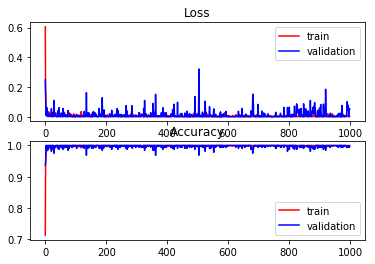

=== Evaluating model: A_A_inceptionv3-dot-final_1000_Nadam.h5 ===

Accuracy: 0.991

Confusion Matrix
[[301   6]
 [  0 333]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.98      0.99       307
          1       0.98      1.00      0.99       333

avg / total       0.99      0.99      0.99       640

=== Evaluating model: A_A_inceptionv3-dot-best_1000_Nadam.h5 ===

Accuracy: 0.998

Confusion Matrix
[[308   1]
 [  0 331]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       309
          1       1.00      1.00      1.00       331

avg / total       1.00      1.00      1.00       640



In [19]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)

# In [17]:
def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = cosine_distance(vecs)
print(s.shape)
# (10,) (10,)
# (10,)
# In [18]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([input_1, input_2]) ###

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [19]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [20]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [21]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "dot", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [22]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [23]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "dot", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 1] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: inceptionv3-dot-final.h5 ===


(10,) (10,)
(10,)
Epoch 1/1000
72/72 [==============================] - 2s 32ms/step - loss: 0.6180 - acc: 0.6411 - val_loss: 0.3889 - val_acc: 0.8531
Epoch 2/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.3338 - acc: 0.8772 - val_loss: 0.0891 - val_acc: 0.9938
Epoch 3/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.1139 - acc: 0.9631 - val_loss: 0.0242 - val_acc: 0.9969
Epoch 4/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0302 - acc: 0.9931 - val_loss: 0.0089 - val_acc: 1.0000
Epoch 5/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0151 - acc: 0.9948 - val_loss: 0.3198 - val_acc: 0.9094
Epoch 6/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0162 - acc: 0.9935 - val_loss: 0.0081 - val_acc: 0.9938
Epoch 7/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0044 - acc: 0.9991 - val_loss: 0.0078 - val_acc: 0.9969
Epoch 8/1000
72/72 [==============================] - 

72/72 [==============================] - 1s 9ms/step - loss: 0.0105 - acc: 0.9978 - val_loss: 4.5175e-04 - val_acc: 1.0000
Epoch 61/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0059 - acc: 0.9978 - val_loss: 0.0053 - val_acc: 0.9969
Epoch 62/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0095 - acc: 0.9987 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 63/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 64/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0045 - acc: 0.9991 - val_loss: 8.5503e-04 - val_acc: 1.0000
Epoch 65/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 5.4342e-04 - val_acc: 1.0000
Epoch 66/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0091 - acc: 0.9983 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 67/1000
72/72 [==============================] - 1s 12ms/step -

72/72 [==============================] - 1s 10ms/step - loss: 6.4211e-04 - acc: 1.0000 - val_loss: 5.0491e-04 - val_acc: 1.0000
Epoch 120/1000
72/72 [==============================] - 1s 9ms/step - loss: 1.1580e-04 - acc: 1.0000 - val_loss: 1.3932e-04 - val_acc: 1.0000
Epoch 121/1000
72/72 [==============================] - 1s 16ms/step - loss: 1.5068e-04 - acc: 1.0000 - val_loss: 2.4785e-04 - val_acc: 1.0000
Epoch 122/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 5.0856e-04 - val_acc: 1.0000
Epoch 123/1000
72/72 [==============================] - 1s 12ms/step - loss: 1.0513e-04 - acc: 1.0000 - val_loss: 1.5687e-04 - val_acc: 1.0000
Epoch 124/1000
72/72 [==============================] - 1s 9ms/step - loss: 6.5121e-05 - acc: 1.0000 - val_loss: 4.5361e-05 - val_acc: 1.0000
Epoch 125/1000
72/72 [==============================] - 1s 8ms/step - loss: 5.2276e-05 - acc: 1.0000 - val_loss: 8.1596e-05 - val_acc: 1.0000
Epoch 126/1000
72/72 [

Epoch 178/1000
72/72 [==============================] - 1s 16ms/step - loss: 1.3887e-04 - acc: 1.0000 - val_loss: 2.0166e-05 - val_acc: 1.0000
Epoch 179/1000
72/72 [==============================] - 1s 8ms/step - loss: 5.5950e-04 - acc: 1.0000 - val_loss: 1.4165e-05 - val_acc: 1.0000
Epoch 180/1000
72/72 [==============================] - 1s 15ms/step - loss: 8.7409e-05 - acc: 1.0000 - val_loss: 1.6077e-05 - val_acc: 1.0000
Epoch 181/1000
72/72 [==============================] - 1s 10ms/step - loss: 6.9981e-05 - acc: 1.0000 - val_loss: 1.4638e-05 - val_acc: 1.0000
Epoch 182/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0038 - acc: 0.9996 - val_loss: 1.8894e-05 - val_acc: 1.0000
Epoch 183/1000
72/72 [==============================] - 1s 12ms/step - loss: 1.3926e-04 - acc: 1.0000 - val_loss: 1.8796e-05 - val_acc: 1.0000
Epoch 184/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.6512e-04 - acc: 1.0000 - val_loss: 5.0124e-05 - val_acc: 1.0000
Epoch 

72/72 [==============================] - 1s 8ms/step - loss: 0.0077 - acc: 0.9974 - val_loss: 2.3312e-04 - val_acc: 1.0000
Epoch 237/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0065 - acc: 0.9987 - val_loss: 2.3324e-04 - val_acc: 1.0000
Epoch 238/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0049 - acc: 0.9991 - val_loss: 1.2731e-04 - val_acc: 1.0000
Epoch 239/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 1.1574e-04 - val_acc: 1.0000
Epoch 240/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0066 - acc: 0.9987 - val_loss: 1.2274e-04 - val_acc: 1.0000
Epoch 241/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0060 - acc: 0.9987 - val_loss: 1.5246e-04 - val_acc: 1.0000
Epoch 242/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 7.7192e-05 - val_acc: 1.0000
Epoch 243/1000
72/72 [=======================

Epoch 295/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 1.5517e-04 - val_acc: 1.0000
Epoch 296/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 1.0848e-04 - val_acc: 1.0000
Epoch 297/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0020 - acc: 0.9996 - val_loss: 1.0731e-04 - val_acc: 1.0000
Epoch 298/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 6.9072e-05 - val_acc: 1.0000
Epoch 299/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 8.7010e-05 - val_acc: 1.0000
Epoch 300/1000
72/72 [==============================] - 1s 15ms/step - loss: 5.3625e-04 - acc: 1.0000 - val_loss: 7.8395e-05 - val_acc: 1.0000
Epoch 301/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 8.0650e-05 - val_acc: 1.0000
Epoch 302/1000
72/72 [====

Epoch 354/1000
72/72 [==============================] - 1s 15ms/step - loss: 4.5447e-04 - acc: 1.0000 - val_loss: 2.2299e-05 - val_acc: 1.0000
Epoch 355/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0015 - acc: 0.9996 - val_loss: 1.8913e-05 - val_acc: 1.0000
Epoch 356/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0031 - acc: 0.9991 - val_loss: 2.3175e-05 - val_acc: 1.0000
Epoch 357/1000
72/72 [==============================] - 1s 17ms/step - loss: 6.3332e-04 - acc: 1.0000 - val_loss: 1.6792e-05 - val_acc: 1.0000
Epoch 358/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0031 - acc: 0.9996 - val_loss: 7.8517e-05 - val_acc: 1.0000
Epoch 359/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0022 - acc: 0.9987 - val_loss: 2.0277e-04 - val_acc: 1.0000
Epoch 360/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 1.0130e-04 - val_acc: 1.0000
Epoch 361/1000
72/72 

Epoch 413/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0037 - acc: 0.9991 - val_loss: 1.9532e-05 - val_acc: 1.0000
Epoch 414/1000
72/72 [==============================] - 1s 16ms/step - loss: 4.8122e-04 - acc: 1.0000 - val_loss: 9.5800e-06 - val_acc: 1.0000
Epoch 415/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0031 - acc: 0.9983 - val_loss: 1.5337e-05 - val_acc: 1.0000
Epoch 416/1000
72/72 [==============================] - 1s 10ms/step - loss: 2.5808e-04 - acc: 1.0000 - val_loss: 1.1305e-05 - val_acc: 1.0000
Epoch 417/1000
72/72 [==============================] - 1s 16ms/step - loss: 5.1420e-04 - acc: 0.9996 - val_loss: 7.6545e-06 - val_acc: 1.0000
Epoch 418/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0021 - acc: 0.9996 - val_loss: 1.3385e-05 - val_acc: 1.0000
Epoch 419/1000
72/72 [==============================] - 1s 13ms/step - loss: 9.6444e-04 - acc: 0.9996 - val_loss: 1.6717e-05 - val_acc: 1.0000
Epoch 420/100

Epoch 472/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0051 - acc: 0.9970 - val_loss: 6.7559e-05 - val_acc: 1.0000
Epoch 473/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0028 - acc: 0.9991 - val_loss: 1.3947e-04 - val_acc: 1.0000
Epoch 474/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0019 - acc: 0.9987 - val_loss: 7.6725e-05 - val_acc: 1.0000
Epoch 475/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0016 - acc: 0.9991 - val_loss: 4.7394e-05 - val_acc: 1.0000
Epoch 476/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0037 - acc: 0.9978 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 477/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0129 - acc: 0.9957 - val_loss: 4.9381e-05 - val_acc: 1.0000
Epoch 478/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0023 - acc: 0.9991 - val_loss: 1.1445e-04 - val_acc: 1.0000
Epoch 479/1000
72/72 [============

Epoch 531/1000
72/72 [==============================] - 1s 11ms/step - loss: 7.4824e-04 - acc: 1.0000 - val_loss: 3.9731e-05 - val_acc: 1.0000
Epoch 532/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0012 - acc: 0.9991 - val_loss: 9.6486e-05 - val_acc: 1.0000
Epoch 533/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0065 - acc: 0.9961 - val_loss: 1.1354e-05 - val_acc: 1.0000
Epoch 534/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0047 - acc: 0.9974 - val_loss: 8.8043e-05 - val_acc: 1.0000
Epoch 535/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0035 - acc: 0.9983 - val_loss: 1.6504e-04 - val_acc: 1.0000
Epoch 536/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0106 - acc: 0.9965 - val_loss: 1.2509e-05 - val_acc: 1.0000
Epoch 537/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0146 - acc: 0.9952 - val_loss: 8.0503e-05 - val_acc: 1.0000
Epoch 538/1000
72/72 [====

Epoch 590/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0011 - acc: 0.9991 - val_loss: 6.7089e-05 - val_acc: 1.0000
Epoch 591/1000
72/72 [==============================] - 1s 12ms/step - loss: 2.2271e-04 - acc: 1.0000 - val_loss: 7.0098e-05 - val_acc: 1.0000
Epoch 592/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0053 - acc: 0.9965 - val_loss: 6.1323e-05 - val_acc: 1.0000
Epoch 593/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 2.4202e-05 - val_acc: 1.0000
Epoch 594/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0030 - acc: 0.9983 - val_loss: 3.0126e-05 - val_acc: 1.0000
Epoch 595/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 1.4684e-05 - val_acc: 1.0000
Epoch 596/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0020 - acc: 0.9991 - val_loss: 7.2978e-06 - val_acc: 1.0000
Epoch 597/1000
72/72 [===

Epoch 649/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0042 - acc: 0.9978 - val_loss: 1.2716e-04 - val_acc: 1.0000
Epoch 650/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0034 - acc: 0.9983 - val_loss: 7.1841e-05 - val_acc: 1.0000
Epoch 651/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0015 - acc: 0.9991 - val_loss: 1.4407e-04 - val_acc: 1.0000
Epoch 652/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0020 - acc: 0.9983 - val_loss: 5.8307e-05 - val_acc: 1.0000
Epoch 653/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 3.8504e-05 - val_acc: 1.0000
Epoch 654/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0019 - acc: 0.9987 - val_loss: 7.6586e-05 - val_acc: 1.0000
Epoch 655/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 5.5700e-05 - val_acc: 1.0000
Epoch 656/1000
72/72 [=======

Epoch 708/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 1.5766e-04 - val_acc: 1.0000
Epoch 709/1000
72/72 [==============================] - 1s 13ms/step - loss: 0.0086 - acc: 0.9974 - val_loss: 8.1628e-05 - val_acc: 1.0000
Epoch 710/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 1.2359e-04 - val_acc: 1.0000
Epoch 711/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0032 - acc: 0.9987 - val_loss: 1.2259e-04 - val_acc: 1.0000
Epoch 712/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0018 - acc: 0.9987 - val_loss: 1.1131e-04 - val_acc: 1.0000
Epoch 713/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0016 - acc: 0.9987 - val_loss: 9.1405e-05 - val_acc: 1.0000
Epoch 714/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0018 - acc: 0.9991 - val_loss: 8.5260e-05 - val_acc: 1.0000
Epoch 715/1000
72/72 [======

Epoch 767/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0093 - acc: 0.9944 - val_loss: 8.5116e-05 - val_acc: 1.0000
Epoch 768/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0092 - acc: 0.9961 - val_loss: 8.0438e-05 - val_acc: 1.0000
Epoch 769/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0048 - acc: 0.9983 - val_loss: 7.4707e-05 - val_acc: 1.0000
Epoch 770/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0059 - acc: 0.9961 - val_loss: 1.0980e-04 - val_acc: 1.0000
Epoch 771/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0086 - acc: 0.9948 - val_loss: 1.1419e-04 - val_acc: 1.0000
Epoch 772/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0069 - acc: 0.9965 - val_loss: 3.6509e-04 - val_acc: 1.0000
Epoch 773/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0070 - acc: 0.9957 - val_loss: 9.1838e-05 - val_acc: 1.0000
Epoch 774/1000
72/72 [======

Epoch 826/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0016 - acc: 0.9987 - val_loss: 4.6069e-05 - val_acc: 1.0000
Epoch 827/1000
72/72 [==============================] - 1s 16ms/step - loss: 0.0017 - acc: 0.9987 - val_loss: 5.7389e-05 - val_acc: 1.0000
Epoch 828/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0014 - acc: 0.9991 - val_loss: 6.5306e-05 - val_acc: 1.0000
Epoch 829/1000
72/72 [==============================] - 1s 15ms/step - loss: 5.3148e-04 - acc: 1.0000 - val_loss: 1.0113e-04 - val_acc: 1.0000
Epoch 830/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0037 - acc: 0.9974 - val_loss: 3.7646e-05 - val_acc: 1.0000
Epoch 831/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0024 - acc: 0.9987 - val_loss: 5.5552e-05 - val_acc: 1.0000
Epoch 832/1000
72/72 [==============================] - 1s 13ms/step - loss: 1.8965e-04 - acc: 1.0000 - val_loss: 3.9914e-05 - val_acc: 1.0000
Epoch 833/1000
72/72

Epoch 885/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0023 - acc: 0.9983 - val_loss: 7.1607e-05 - val_acc: 1.0000
Epoch 886/1000
72/72 [==============================] - 1s 15ms/step - loss: 9.9043e-04 - acc: 0.9991 - val_loss: 4.5839e-05 - val_acc: 1.0000
Epoch 887/1000
72/72 [==============================] - 1s 13ms/step - loss: 3.9776e-04 - acc: 1.0000 - val_loss: 3.3683e-05 - val_acc: 1.0000
Epoch 888/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0038 - acc: 0.9987 - val_loss: 8.5571e-05 - val_acc: 1.0000
Epoch 889/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 1.3335e-04 - val_acc: 1.0000
Epoch 890/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0015 - acc: 0.9991 - val_loss: 1.1347e-04 - val_acc: 1.0000
Epoch 891/1000
72/72 [==============================] - 1s 17ms/step - loss: 0.0016 - acc: 0.9991 - val_loss: 6.2733e-05 - val_acc: 1.0000
Epoch 892/1000
72/7

Epoch 944/1000
72/72 [==============================] - 1s 19ms/step - loss: 9.4049e-05 - acc: 1.0000 - val_loss: 6.0533e-05 - val_acc: 1.0000
Epoch 945/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0044 - acc: 0.9978 - val_loss: 1.2441e-04 - val_acc: 1.0000
Epoch 946/1000
72/72 [==============================] - 1s 14ms/step - loss: 3.7553e-04 - acc: 1.0000 - val_loss: 1.0800e-04 - val_acc: 1.0000
Epoch 947/1000
72/72 [==============================] - 1s 17ms/step - loss: 8.8130e-04 - acc: 0.9996 - val_loss: 1.5156e-04 - val_acc: 1.0000
Epoch 948/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0010 - acc: 0.9996 - val_loss: 1.4489e-04 - val_acc: 1.0000
Epoch 949/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0032 - acc: 0.9996 - val_loss: 2.7577e-04 - val_acc: 1.0000
Epoch 950/1000
72/72 [==============================] - 1s 15ms/step - loss: 4.1973e-04 - acc: 1.0000 - val_loss: 1.9985e-04 - val_acc: 1.0000
Epoch 951/10

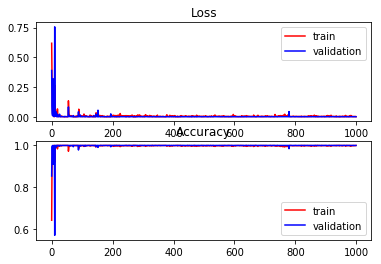

=== Evaluating model: A_A_inceptionv3-l1-final_1000_Nadam.h5 ===

Accuracy: 1.000

Confusion Matrix
[[312   0]
 [  0 328]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       312
          1       1.00      1.00      1.00       328

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_inceptionv3-l1-best_1000_Nadam.h5 ===

Accuracy: 1.000

Confusion Matrix
[[308   0]
 [  0 332]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       308
          1       1.00      1.00      1.00       332

avg / total       1.00      1.00      1.00       640



In [20]:
# In [24]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [25]:
def absdiff(vecs):
    x, y = vecs
    return K.abs(K.sum(K.stack([x, -y], axis=1), axis=1))

'''
abs 元素级的绝对值操作。
'''

def absdiff_output_shape(shapes):
    return shapes[0]

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = absdiff(vecs)
print(s.shape)

# In [26]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(absdiff, output_shape=absdiff_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [27]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [28]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [29]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "l1", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [30]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [31]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "l1", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 2] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: inceptionv3-l1-final.h5 ===

(10,) (10,)
(10,)
Epoch 1/1000
72/72 [==============================] - 2s 32ms/step - loss: 0.6402 - acc: 0.6094 - val_loss: 0.4068 - val_acc: 0.8781
Epoch 2/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.3040 - acc: 0.8885 - val_loss: 0.1505 - val_acc: 0.9594
Epoch 3/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.1285 - acc: 0.9562 - val_loss: 0.0807 - val_acc: 0.9781
Epoch 4/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0628 - acc: 0.9809 - val_loss: 0.1107 - val_acc: 0.9656
Epoch 5/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0595 - acc: 0.9805 - val_loss: 0.0429 - val_acc: 0.9750
Epoch 6/1000
72/72 [==============================] - 1s 12ms/step - loss: 0.0410 - acc: 0.9874 - val_loss: 0.0468 - val_acc: 0.9938
Epoch 7/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0382 - acc: 0.9896 - val_loss: 0.0318 - val_acc: 0.9844
Epoch 8/1000
72/72 [==============================] - 

72/72 [==============================] - 1s 8ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0078 - val_acc: 0.9938
Epoch 63/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0245 - acc: 0.9948 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 64/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0143 - acc: 0.9965 - val_loss: 0.0202 - val_acc: 0.9906
Epoch 65/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0143 - val_acc: 0.9969
Epoch 66/1000
72/72 [==============================] - 1s 11ms/step - loss: 0.0024 - acc: 0.9991 - val_loss: 0.0124 - val_acc: 0.9969
Epoch 67/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0367 - acc: 0.9913 - val_loss: 0.0165 - val_acc: 0.9906
Epoch 68/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0224 - acc: 0.9939 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 69/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.00

72/72 [==============================] - 1s 11ms/step - loss: 9.5329e-04 - acc: 0.9996 - val_loss: 0.0039 - val_acc: 0.9969
Epoch 123/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0082 - acc: 0.9987 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 124/1000
72/72 [==============================] - 1s 12ms/step - loss: 1.9709e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 125/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.6521e-04 - acc: 1.0000 - val_loss: 3.9452e-04 - val_acc: 1.0000
Epoch 126/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 127/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0032 - acc: 0.9991 - val_loss: 1.7776e-04 - val_acc: 1.0000
Epoch 128/1000
72/72 [==============================] - 1s 19ms/step - loss: 4.3766e-04 - acc: 1.0000 - val_loss: 1.2366e-04 - val_acc: 1.0000
Epoch 129/1000
72/72 [=======================

72/72 [==============================] - 1s 8ms/step - loss: 1.4896e-04 - acc: 1.0000 - val_loss: 0.0029 - val_acc: 0.9969
Epoch 182/1000
72/72 [==============================] - 1s 14ms/step - loss: 7.0708e-05 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 183/1000
72/72 [==============================] - 1s 8ms/step - loss: 7.0691e-05 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 184/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 185/1000
72/72 [==============================] - 1s 10ms/step - loss: 5.2079e-05 - acc: 1.0000 - val_loss: 0.0051 - val_acc: 0.9969
Epoch 186/1000
72/72 [==============================] - 1s 19ms/step - loss: 4.2332e-05 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 187/1000
72/72 [==============================] - 1s 8ms/step - loss: 3.9221e-05 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 188/1000
72/72 [============================

Epoch 241/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.6301e-04 - acc: 1.0000 - val_loss: 0.0244 - val_acc: 0.9969
Epoch 242/1000
72/72 [==============================] - 1s 8ms/step - loss: 5.4934e-05 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9969
Epoch 243/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0036 - acc: 0.9987 - val_loss: 0.0149 - val_acc: 0.9969
Epoch 244/1000
72/72 [==============================] - 1s 19ms/step - loss: 0.0021 - acc: 0.9987 - val_loss: 0.0527 - val_acc: 0.9938
Epoch 245/1000
72/72 [==============================] - 1s 9ms/step - loss: 6.4156e-04 - acc: 0.9996 - val_loss: 0.0607 - val_acc: 0.9938
Epoch 246/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.5155e-04 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9938
Epoch 247/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.6553e-04 - acc: 1.0000 - val_loss: 1.4793e-04 - val_acc: 1.0000
Epoch 248/1000
72/72 [===============

72/72 [==============================] - 1s 8ms/step - loss: 5.1163e-05 - acc: 1.0000 - val_loss: 3.7591e-05 - val_acc: 1.0000
Epoch 301/1000
72/72 [==============================] - 1s 8ms/step - loss: 3.5626e-04 - acc: 1.0000 - val_loss: 9.4090e-05 - val_acc: 1.0000
Epoch 302/1000
72/72 [==============================] - 1s 18ms/step - loss: 0.0024 - acc: 0.9991 - val_loss: 1.2293e-04 - val_acc: 1.0000
Epoch 303/1000
72/72 [==============================] - 1s 10ms/step - loss: 0.0024 - acc: 0.9996 - val_loss: 2.3371e-04 - val_acc: 1.0000
Epoch 304/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 305/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0034 - acc: 0.9996 - val_loss: 1.8715e-04 - val_acc: 1.0000
Epoch 306/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0124 - acc: 0.9983 - val_loss: 4.2546e-04 - val_acc: 1.0000
Epoch 307/1000
72/72 [=====================

72/72 [==============================] - 1s 8ms/step - loss: 1.9471e-05 - acc: 1.0000 - val_loss: 1.4801e-04 - val_acc: 1.0000
Epoch 360/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.8494e-05 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.9969
Epoch 361/1000
72/72 [==============================] - 1s 18ms/step - loss: 1.6697e-05 - acc: 1.0000 - val_loss: 0.0068 - val_acc: 0.9969
Epoch 362/1000
72/72 [==============================] - 1s 11ms/step - loss: 1.4482e-05 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 0.9938
Epoch 363/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.3780e-05 - acc: 1.0000 - val_loss: 0.0053 - val_acc: 0.9969
Epoch 364/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.1419e-05 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 0.9969
Epoch 365/1000
72/72 [==============================] - 1s 12ms/step - loss: 8.4483e-05 - acc: 1.0000 - val_loss: 0.0046 - val_acc: 0.9969
Epoch 366/1000
72/72 [====================

72/72 [==============================] - 1s 8ms/step - loss: 2.0621e-05 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9938
Epoch 419/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.0941e-05 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9938
Epoch 420/1000
72/72 [==============================] - 1s 20ms/step - loss: 0.0016 - acc: 0.9996 - val_loss: 0.0163 - val_acc: 0.9938
Epoch 421/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 1.0488e-04 - val_acc: 1.0000
Epoch 422/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.3262e-04 - acc: 0.9996 - val_loss: 2.2952e-05 - val_acc: 1.0000
Epoch 423/1000
72/72 [==============================] - 1s 8ms/step - loss: 5.8132e-06 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 0.9938
Epoch 424/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0066 - acc: 0.9996 - val_loss: 0.0109 - val_acc: 0.9938
Epoch 425/1000
72/72 [=============================

72/72 [==============================] - 1s 8ms/step - loss: 8.6710e-05 - acc: 1.0000 - val_loss: 1.8539e-04 - val_acc: 1.0000
Epoch 478/1000
72/72 [==============================] - 1s 17ms/step - loss: 2.9684e-05 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 479/1000
72/72 [==============================] - 1s 11ms/step - loss: 1.5565e-05 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 480/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.1835e-05 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 481/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.3709e-05 - acc: 1.0000 - val_loss: 2.1778e-05 - val_acc: 1.0000
Epoch 482/1000
72/72 [==============================] - 1s 14ms/step - loss: 3.3471e-05 - acc: 1.0000 - val_loss: 1.9234e-04 - val_acc: 1.0000
Epoch 483/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0103 - acc: 0.9987 - val_loss: 1.1897e-04 - val_acc: 1.0000
Epoch 484/1000
72/72 [============

72/72 [==============================] - 1s 8ms/step - loss: 5.2662e-06 - acc: 1.0000 - val_loss: 2.5486e-04 - val_acc: 1.0000
Epoch 536/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.9697e-06 - acc: 1.0000 - val_loss: 2.1196e-04 - val_acc: 1.0000
Epoch 537/1000
72/72 [==============================] - 1s 20ms/step - loss: 4.7114e-06 - acc: 1.0000 - val_loss: 1.8269e-04 - val_acc: 1.0000
Epoch 538/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.0702e-06 - acc: 1.0000 - val_loss: 1.4669e-04 - val_acc: 1.0000
Epoch 539/1000
72/72 [==============================] - 1s 8ms/step - loss: 9.3463e-05 - acc: 1.0000 - val_loss: 1.7465e-05 - val_acc: 1.0000
Epoch 540/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.1319e-06 - acc: 1.0000 - val_loss: 4.8318e-07 - val_acc: 1.0000
Epoch 541/1000
72/72 [==============================] - 1s 15ms/step - loss: 9.9034e-07 - acc: 1.0000 - val_loss: 5.3160e-07 - val_acc: 1.0000
Epoch 542/1000
72/7

72/72 [==============================] - 1s 10ms/step - loss: 4.1125e-06 - acc: 1.0000 - val_loss: 0.0411 - val_acc: 0.9969
Epoch 595/1000
72/72 [==============================] - 1s 18ms/step - loss: 4.2903e-06 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9969
Epoch 596/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.8997e-06 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9969
Epoch 597/1000
72/72 [==============================] - 1s 8ms/step - loss: 5.2249e-05 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9969
Epoch 598/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.1068 - val_acc: 0.9906
Epoch 599/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0054 - acc: 0.9996 - val_loss: 0.0255 - val_acc: 0.9938
Epoch 600/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.3628e-06 - acc: 1.0000 - val_loss: 0.0111 - val_acc: 0.9969
Epoch 601/1000
72/72 [==============================] 

72/72 [==============================] - 1s 17ms/step - loss: 9.4037e-06 - acc: 1.0000 - val_loss: 2.7551e-06 - val_acc: 1.0000
Epoch 654/1000
72/72 [==============================] - 1s 10ms/step - loss: 7.5610e-06 - acc: 1.0000 - val_loss: 3.8599e-06 - val_acc: 1.0000
Epoch 655/1000
72/72 [==============================] - 1s 8ms/step - loss: 7.0865e-06 - acc: 1.0000 - val_loss: 2.0806e-07 - val_acc: 1.0000
Epoch 656/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0057 - acc: 0.9996 - val_loss: 0.0504 - val_acc: 0.9969
Epoch 657/1000
72/72 [==============================] - 1s 14ms/step - loss: 0.0199 - acc: 0.9974 - val_loss: 4.4756e-05 - val_acc: 1.0000
Epoch 658/1000
72/72 [==============================] - 1s 9ms/step - loss: 0.0104 - acc: 0.9991 - val_loss: 3.9211e-04 - val_acc: 1.0000
Epoch 659/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0235 - acc: 0.9978 - val_loss: 5.2522e-04 - val_acc: 1.0000
Epoch 660/1000
72/72 [================

Epoch 712/1000
72/72 [==============================] - 1s 14ms/step - loss: 3.1713e-06 - acc: 1.0000 - val_loss: 0.0501 - val_acc: 0.9969
Epoch 713/1000
72/72 [==============================] - 1s 8ms/step - loss: 3.1476e-06 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9969
Epoch 714/1000
72/72 [==============================] - 1s 8ms/step - loss: 3.2628e-06 - acc: 1.0000 - val_loss: 0.1008 - val_acc: 0.9938
Epoch 715/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9991 - val_loss: 0.0384 - val_acc: 0.9969
Epoch 716/1000
72/72 [==============================] - 1s 15ms/step - loss: 0.0070 - acc: 0.9996 - val_loss: 0.0354 - val_acc: 0.9969
Epoch 717/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.1029e-06 - acc: 1.0000 - val_loss: 4.4871e-07 - val_acc: 1.0000
Epoch 718/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.4759e-06 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9969
Epoch 719/1000
72/72 [==============

72/72 [==============================] - 1s 8ms/step - loss: 0.0022 - acc: 0.9996 - val_loss: 0.0569 - val_acc: 0.9906
Epoch 772/1000
72/72 [==============================] - 1s 8ms/step - loss: 3.6885e-04 - acc: 0.9996 - val_loss: 0.0142 - val_acc: 0.9969
Epoch 773/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.1479e-06 - acc: 1.0000 - val_loss: 0.0279 - val_acc: 0.9938
Epoch 774/1000
72/72 [==============================] - 1s 15ms/step - loss: 1.4713e-06 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9938
Epoch 775/1000
72/72 [==============================] - 1s 8ms/step - loss: 6.4122e-07 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 0.9969
Epoch 776/1000
72/72 [==============================] - 1s 8ms/step - loss: 6.4569e-07 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 0.9969
Epoch 777/1000
72/72 [==============================] - 1s 8ms/step - loss: 8.1053e-07 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9969
Epoch 778/1000
72/72 [==============================

72/72 [==============================] - 1s 14ms/step - loss: 8.9876e-07 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 830/1000
72/72 [==============================] - 1s 8ms/step - loss: 8.0632e-07 - acc: 1.0000 - val_loss: 2.0433e-06 - val_acc: 1.0000
Epoch 831/1000
72/72 [==============================] - 1s 8ms/step - loss: 9.7986e-07 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 0.9969
Epoch 832/1000
72/72 [==============================] - 1s 9ms/step - loss: 8.5571e-07 - acc: 1.0000 - val_loss: 0.0045 - val_acc: 0.9938
Epoch 833/1000
72/72 [==============================] - 1s 14ms/step - loss: 1.3447e-06 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 0.9969
Epoch 834/1000
72/72 [==============================] - 1s 8ms/step - loss: 7.1435e-07 - acc: 1.0000 - val_loss: 2.6917e-06 - val_acc: 1.0000
Epoch 835/1000
72/72 [==============================] - 1s 9ms/step - loss: 7.0781e-07 - acc: 1.0000 - val_loss: 7.2811e-07 - val_acc: 1.0000
Epoch 836/1000
72/72 [=============

Epoch 887/1000
72/72 [==============================] - 1s 18ms/step - loss: 5.1288e-07 - acc: 1.0000 - val_loss: 1.4261e-05 - val_acc: 1.0000
Epoch 888/1000
72/72 [==============================] - 1s 8ms/step - loss: 5.7261e-07 - acc: 1.0000 - val_loss: 8.6212e-04 - val_acc: 1.0000
Epoch 889/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.5239e-07 - acc: 1.0000 - val_loss: 8.9075e-04 - val_acc: 1.0000
Epoch 890/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.4129e-07 - acc: 1.0000 - val_loss: 8.8332e-04 - val_acc: 1.0000
Epoch 891/1000
72/72 [==============================] - 1s 15ms/step - loss: 4.6530e-07 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 892/1000
72/72 [==============================] - 1s 8ms/step - loss: 5.0721e-07 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 893/1000
72/72 [==============================] - 1s 8ms/step - loss: 4.7001e-07 - acc: 1.0000 - val_loss: 9.4727e-04 - val_acc: 1.0000
Epoch 894/10

72/72 [==============================] - 1s 17ms/step - loss: 1.3390e-07 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 946/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0050 - acc: 0.9987 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 947/1000
72/72 [==============================] - 1s 8ms/step - loss: 0.0023 - acc: 0.9987 - val_loss: 2.5130e-04 - val_acc: 1.0000
Epoch 948/1000
72/72 [==============================] - 1s 8ms/step - loss: 1.8678e-07 - acc: 1.0000 - val_loss: 1.1244e-04 - val_acc: 1.0000
Epoch 949/1000
72/72 [==============================] - 1s 15ms/step - loss: 2.1828e-06 - acc: 1.0000 - val_loss: 1.3571e-05 - val_acc: 1.0000
Epoch 950/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.1364e-07 - acc: 1.0000 - val_loss: 7.8486e-06 - val_acc: 1.0000
Epoch 951/1000
72/72 [==============================] - 1s 8ms/step - loss: 2.8609e-07 - acc: 1.0000 - val_loss: 4.3368e-06 - val_acc: 1.0000
Epoch 952/1000
72/72 [=============

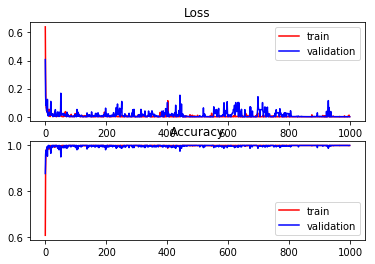

=== Evaluating model: A_A_inceptionv3-l2-final_1000_Nadam.h5 ===

Accuracy: 0.998

Confusion Matrix
[[310   1]
 [  0 329]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       311
          1       1.00      1.00      1.00       329

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_inceptionv3-l2-best_1000_Nadam.h5 ===

Accuracy: 0.997

Confusion Matrix
[[310   2]
 [  0 328]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       312
          1       0.99      1.00      1.00       328

avg / total       1.00      1.00      1.00       640



In [21]:
# Input: Elementwise Euclidean Distance
# In [32]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [33]:
def euclidean_distance(vecs):
    x, y = vecs
    return K.sqrt(K.sum(K.stack([K.square(x), -K.square(y)], axis=1), axis=1))

'''
stack  将秩 为 R 的张量列表堆叠成秩为 R + 1 的张量。
square 元素级的平方操作。
sum    计算张量在某一指定轴的和。
sqrt   元素级的平方根操作。
'''

def euclidean_distance_output_shape(shapes):
    xshape, yshape = shapes
    return xshape

vecs = [np.random.random((10,)), np.random.random((10,))]
print(vecs[0].shape, vecs[1].shape)
s = euclidean_distance(vecs)
print(s.shape)

# In [34]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(euclidean_distance, 
                output_shape=euclidean_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [35]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [36]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [37]:
best_model_name = get_model_file(DATA_DIR, "inceptionv3", "l2", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [39]:
final_model_name = get_model_file(DATA_DIR, "inceptionv3", "l2", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[0, 3] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: inceptionv3-l2-final.h5 ===

=== Evaluating model: A_A_resnet50-cat-final_10.h5 ===

Accuracy: 0.995

Confusion Matrix
[[306   2]
 [  1 331]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       308
          1       0.99      1.00      1.00       332

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_inceptionv3-l2-best_10.h5 ===

Accuracy: 0.995

Confusion Matrix
[[311   2]
 [  1 326]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       313
          1       0.99      1.00      1.00       327

avg / total       1.00      1.00      1.00       640

Epoch 1/10
72/72 [==============================] - 3s 36ms/step - loss: 0.5344 - acc: 0.7292 - val_loss: 0.2602 - val_acc: 0.9219
Epoch 2/10
72/72 [==============================] - 1s 14ms/step - loss: 0.1692 - acc: 0.9440 - val_loss: 0.1010 - val_acc: 0.9750
Epoch 3/10
72/72 [=================

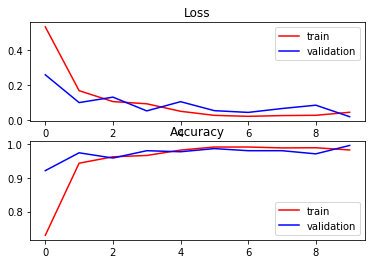

In [32]:
# In [48]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "cat", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 0] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-cat-final.h5 ===


# Input: Elementwise Cosine Distance
# In [49]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [50]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [51]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [52]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [53]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "dot", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [54]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

Epoch 1/10
72/72 [==============================] - 3s 44ms/step - loss: 0.7965 - acc: 0.5668 - val_loss: 0.5289 - val_acc: 0.7688
Epoch 2/10
72/72 [==============================] - 1s 20ms/step - loss: 0.4306 - acc: 0.7999 - val_loss: 0.2926 - val_acc: 0.9062
Epoch 3/10
72/72 [==============================] - 1s 20ms/step - loss: 0.2032 - acc: 0.9236 - val_loss: 0.2457 - val_acc: 0.8969
Epoch 4/10
72/72 [==============================] - 1s 20ms/step - loss: 0.1458 - acc: 0.9488 - val_loss: 0.1218 - val_acc: 0.9656
Epoch 5/10
72/72 [==============================] - 1s 21ms/step - loss: 0.0832 - acc: 0.9740 - val_loss: 0.1672 - val_acc: 0.9469
Epoch 6/10
72/72 [==============================] - 1s 20ms/step - loss: 0.0740 - acc: 0.9740 - val_loss: 0.0930 - val_acc: 0.9625
Epoch 7/10
72/72 [==============================] - 1s 20ms/step - loss: 0.0473 - acc: 0.9857 - val_loss: 0.0958 - val_acc: 0.9688
Epoch 8/10
72/72 [==============================] - 1s 20ms/step - loss: 0.0410 - a

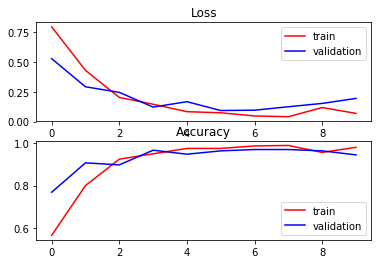

In [33]:
# ResNet 50 Vectors
# In [40]:
VECTOR_SIZE = 2048
VECTOR_FILE = os.path.join(DATA_DIR,"weights" , "accton-resnet-vectors.tsv")
# In [41]:
vec_dict = load_vectors(VECTOR_FILE)
# Input: Concatenate vectors
# In [42]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [43]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Concatenate(axis=-1)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [44]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [45]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [46]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "cat", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [47]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

=== Evaluating model: A_A_resnet50-dot-final_10.h5 ===

Accuracy: 0.953

Confusion Matrix
[[279  30]
 [  0 331]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.90      0.95       309
          1       0.92      1.00      0.96       331

avg / total       0.96      0.95      0.95       640

=== Evaluating model: A_A_resnet50-cat-best_10.h5 ===

Accuracy: 0.964

Confusion Matrix
[[292  21]
 [  2 325]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.93      0.96       313
          1       0.94      0.99      0.97       327

avg / total       0.97      0.96      0.96       640

Epoch 1/10
72/72 [==============================] - 3s 39ms/step - loss: 0.4064 - acc: 0.8138 - val_loss: 0.1506 - val_acc: 0.9531
Epoch 2/10
72/72 [==============================] - 1s 14ms/step - loss: 0.0696 - acc: 0.9852 - val_loss: 0.0622 - val_acc: 0.9938
Epoch 3/10
72/72 [===================

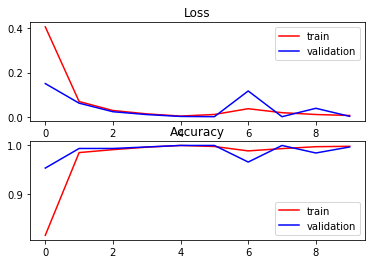

=== Evaluating model: A_A_resnet50-l1-final_10.h5 ===

Accuracy: 1.000

Confusion Matrix
[[310   0]
 [  0 330]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       310
          1       1.00      1.00      1.00       330

avg / total       1.00      1.00      1.00       640

=== Evaluating model: A_A_resnet50-l1-best_10.h5 ===

Accuracy: 1.000

Confusion Matrix
[[309   0]
 [  0 331]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       309
          1       1.00      1.00      1.00       331

avg / total       1.00      1.00      1.00       640

Epoch 1/10
72/72 [==============================] - 3s 41ms/step - loss: 0.5162 - acc: 0.7201 - val_loss: 0.2774 - val_acc: 0.9094
Epoch 2/10
72/72 [==============================] - 1s 14ms/step - loss: 0.1990 - acc: 0.9345 - val_loss: 0.2373 - val_acc: 0.9375
Epoch 3/10
72/72 [=====================

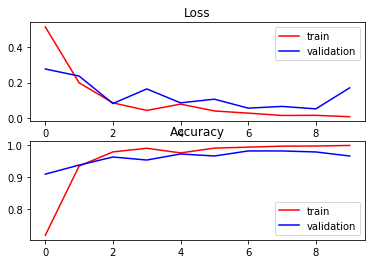

=== Evaluating model: A_A_resnet50-l2-final_10.h5 ===

Accuracy: 0.964

Confusion Matrix
[[287  23]
 [  0 330]]

Classification Report
             precision    recall  f1-score   support

          0       1.00      0.93      0.96       310
          1       0.93      1.00      0.97       330

avg / total       0.97      0.96      0.96       640

=== Evaluating model: A_A_resnet50-l2-best_10.h5 ===

Accuracy: 0.994

Confusion Matrix
[[306   2]
 [  2 330]]

Classification Report
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       308
          1       0.99      0.99      0.99       332

avg / total       0.99      0.99      0.99       640



In [34]:
# In [55]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "dot", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 1] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-dot-final.h5 ===

# Input: Elementwise Absolute Difference
# In [56]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [57]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(absdiff, output_shape=absdiff_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [58]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [59]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [60]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "l1", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [62]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "l1", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 2] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-l1-final.h5 ===


# Input: Elementwise Euclidean Distance
# In [63]:
train_gen = data_generator(train_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
val_gen = data_generator(val_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
# In [64]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Lambda(euclidean_distance, 
                output_shape=euclidean_distance_output_shape)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)
# In [65]:
model = Model(inputs=[input_1, input_2], outputs=pred)
# model.summary()
# In [66]:
model.compile(optimizer="Nadam", loss="categorical_crossentropy", metrics=["accuracy"])
# In [67]:
best_model_name = get_model_file(DATA_DIR, "resnet50", "l2", "best")
checkpoint = ModelCheckpoint(best_model_name, save_best_only=True)
train_steps_per_epoch = len(train_triples) // BATCH_SIZE
val_steps_per_epoch = len(val_triples) // BATCH_SIZE
history = model.fit_generator(train_gen, steps_per_epoch=train_steps_per_epoch, 
                              epochs=NUM_EPOCHS, 
                              validation_data=val_gen, validation_steps=val_steps_per_epoch,
                              callbacks=[checkpoint])

# In [68]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.show()

# In [69]:
final_model_name = get_model_file(DATA_DIR, "resnet50", "l2", "final")
model.save(final_model_name)
test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
final_accuracy = evaluate_model(final_model_name, test_gen)

test_gen = data_generator(test_triples, VECTOR_SIZE, vec_dict, BATCH_SIZE)
best_accuracy = evaluate_model(best_model_name, test_gen)

scores[1, 3] = best_accuracy if best_accuracy > final_accuracy else final_accuracy
# === Evaluating model: resnet50-l2-final.h5 ===

Text(0.5,1,'Neural Network Classifiers with Image Vectors')

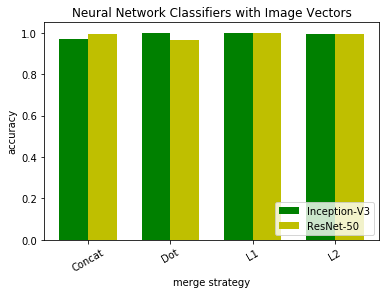

In [35]:
# In [71]:
width=0.35
plt.bar(np.arange(scores.shape[1]), scores[0], width, color="g", label="Inception-V3")
plt.bar(np.arange(scores.shape[1])+width, scores[1], width, color="y", label="ResNet-50")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xlabel("merge strategy")
plt.xticks(np.arange(scores.shape[1])+0.5*width, ["Concat", "Dot", "L1", "L2"],
          rotation=30)
plt.title("Neural Network Classifiers with Image Vectors")
# Out[71]:
# <matplotlib.text.Text at 0x7fe1aa6d1050>

# In [ ]: